In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumtrapz

In [7]:
%matplotlib inline

In diesem Notebook wird das das dynamische lineare Einspurmodell implementiert.

![schema](https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/EinspurKinematik.png/370px-EinspurKinematik.png)

![dgl-system](assets/dgl-system.png)

für die DGL setzen wir:

\begin{equation}
\dot\phi = \omega
\end{equation}

In [106]:
c_v = 100000
c_h = 160000
m = 1900
l_v = 1.5
l_h = 1.4
J = 3400

Input function:

In [220]:
def f1(t):
    f = 0.1
    a_rad = 1*2*np.pi/360
    return a_rad*np.sin(2*np.pi*f*t)

In [221]:
def step(t, thres=150):
    r = 0.2*2*np.pi/360
    if t<thres and t>10:
        return r
    elif t>=thres and t<290:
        return -r
    else:
        return 0

In [222]:
def f2(t):
    if isinstance(t, np.ndarray):
        r = np.ones_like(t)
        for i in range(r.size):
            r[i] = step(t[i])
        return r
    else:
        return step(t)

In [263]:
def f3(t):
    f = 0.1
    a_rad = 1*2*np.pi/360
    return 0.001*t*a_rad*np.sin(2*np.pi*f*t)

In [319]:
def f4(t):
    if isinstance(t, np.ndarray):
        r = np.ones_like(t)
        return 1/360*2*np.pi*r
    else:
        return 1/360*2*np.pi

In [320]:
def δ_v(t):
    return f4(t)

In [321]:
T_sim = 300
N_steps = T_sim*1000

In [322]:
t = np.linspace(0, T_sim, N_steps)

No handles with labels found to put in legend.


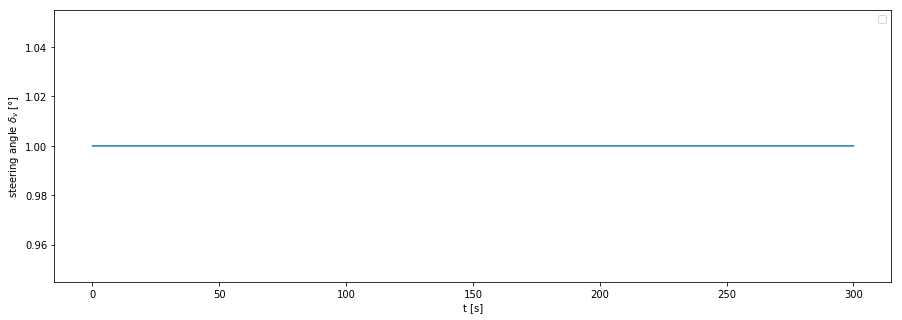

In [323]:
plt.figure(figsize=(15,5))
plt.plot(t, δ_v(t)*360/(2*np.pi))
plt.xlabel("t [s]")
plt.ylabel("steering angle $δ_v$ [°]")
plt.legend()

In [324]:
def transition_model(t, state):
    v, β, 𝜔 = state
    v_dot = c_v/m*δ_v(t) + c_v*l_v/(m*v)*δ_v(t)*𝜔 - c_v/m*δ_v(t)**2
    β_dot = - (c_v+c_h)/(m*v)*β + (-1 + (c_h*l_h-c_v*l_v)/(m*v**2))*𝜔 + c_v/(m*v)*δ_v(t)
    𝜔_dot = (c_h*l_h-c_v*l_v)/J*β - (c_h*l_h**2 + c_v*l_v**2)/(J*v)*𝜔 + c_v*l_v/J*δ_v(t)
    return np.r_[v_dot, β_dot, 𝜔_dot]

In [325]:
initial_state = np.r_[22, 0, 0]

In [326]:
integral_range = [0, t.max()]

In [327]:
result = solve_ivp(transition_model, integral_range, y0=initial_state, t_eval=t)

![transformation](assets/transformation-into-normal.png)

In [328]:
def get_position_in_normal_axis(t, v, β, 𝜔):
    phi = cumtrapz(𝜔, t, initial=0)
    v_xN, v_yN = np.zeros_like(t), np.zeros_like(t)
    for i, v_i in enumerate(np.nditer(v)):
        v_x_i, v_y_i = v_i*np.cos(β[i]), v_i*np.sin(β[i])
        v_xN[i] = v_x_i*np.cos(phi[i]) + v_y_i*np.sin(-phi[i])
        v_yN[i] = v_x_i*np.sin(phi[i]) + v_y_i*np.cos(-phi[i])
    s_xN = cumtrapz(v_xN, t, initial=0)
    s_yN = cumtrapz(v_yN, t, initial=0)
    return s_xN, s_yN

In [329]:
v, β, 𝜔 = result.y[0, :], result.y[1, :], result.y[2, :]

In [330]:
s_xN, s_yN = get_position_in_normal_axis(t, v, β, 𝜔)

Text(0.5, 1.0, 'Position im Raum über Zeit')

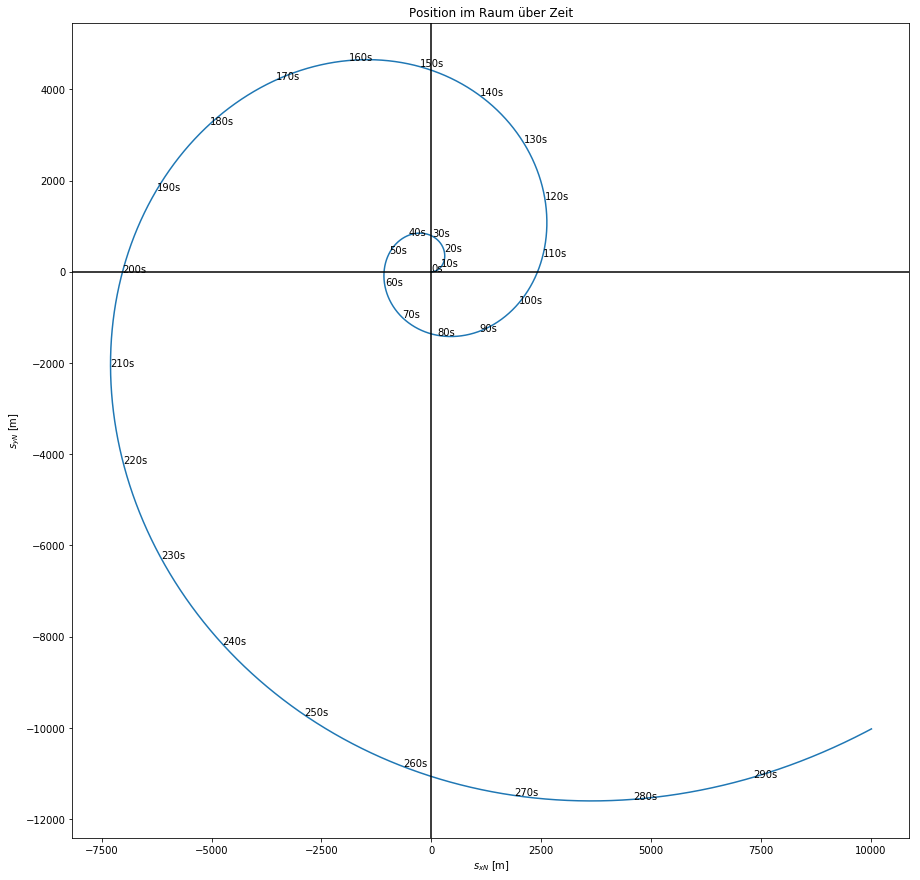

In [331]:
plt.figure(figsize=(15,15))
plt.plot(s_xN, s_yN)
for sec in range(0, T_sim, 10):
    j = np.argmax(t>sec)
    plt.text(s_xN[j], s_yN[j], "%ds" % sec)
plt.xlabel("$s_{xN}$ [m]")
plt.ylabel("$s_{yN}$ [m]")
smax = max(s_xN.max(), s_yN.max())
#plt.xlim([-smax*0.1, smax])
#plt.ylim([-smax*0.1, smax])
plt.axhline(0, color="k")
plt.axvline(0, color="k")
plt.title("Position im Raum über Zeit")